In [1]:
import os
os.chdir('..')  # go up to the project directory

In [2]:
import shutil
import matplotlib.pyplot as plt
from pathlib import Path

import src
from src.vault import get_vault
from src.nlp import VaultNLP
from src.moc import auto_generate_MOCs

In [3]:
%matplotlib inline

# Proof of concept

I have an Obsidian.md vault with these characteristics:
- 550+ files (800+ notes when including files not yet created)
- 130k+ words of content across the vault

These notes were used for studying 11 modules as part of my degree.  I used it like a personal wiki.

Hence the notes had natural ['categories'](https://notes.linkingyourthinking.com/Cards/Why+Categories+for+Your+Notes+are+a+Good+Idea), which I grouped into folders: I did not use Maps of Content (MOCs).

The vault is an interesting test case for auto-generating MOCs from its content.  These are reasons why I want to develop MOCs (from [advantages](https://notes.linkingyourthinking.com/Cards/MOCs+Overview) in the LYT kit):
- Better navigation of my vault
- Convenient reference points for my modules
- Help with spatial relationships

In [4]:
%%time
VAULT = get_vault('MPHIL_VAULT_DIR')

CPU times: user 21.3 s, sys: 177 ms, total: 21.5 s
Wall time: 22.1 s


In [5]:
df = VAULT.get_note_metadata()

In [6]:
df.shape

(800, 7)

In [7]:
print(f"Notes with content: {df[df['note_exists']].shape[0]}")

Notes with content: 561


This code is a **proof of concept** for _**auto-generating MOCs via topic modelling**_.

I use the **[Anchored CorEx algorithm](https://github.com/gregversteeg/corex_topic)** to create one MOC per module, to mirror the modules I studied for my degree.  In essence, the aim for the MOCs is to generate an index of the most important notes for each module.  See the _References_ section at the end of this notebook for the paper.

**The beauty of this approach:**
- The user specifies keywords (anchor words) for each topic.  This is _semi-supervised learning_, so **the user can nudge the algorithm** to group notes into topics that have some context set by the user.  The user can do incremental changes to the implementation to aim for more intuitive results.
- It relies solely on the text within notes: the implementation **does NOT use detail from wikilinks**, i.e. it has zero information on any relationships between notes.  I've noticed that some approaches for MOC generation in Obsidian.md plug-ins rely on wikilinks to build structure (e.g. [Robin Haupt's plug-in](https://github.com/Robin-Haupt-1/Obsidian-Map-of-Content)), whereas this approach does not!  If the user has neglected the creation of wikilinks over time, in a complex vault, that shouldn't matter for the MOC generation here.

The knowledge graph for my vault is shown below, with notes coloured by module.  The MOCs that were generated from this repo's code are coloured white.

![Knowledge graph](img/MPhil_knowledge-graph_2022-08.png)

# Topic modelling

This section has the code that covers the topic modelling.  With a few tweaks to the code, it could be re-applied to another vault.

These are some of the main inputs to tweak:
- Number of topics
- Anchor words for topics _(the most important for improving results)_
- Anchor strength

The tutorial notebook has more detail on how to choose the number of topics.  For this vault, it was straightforward to choose 11 as I have 11 modules on my degree, so I aim to have one topic to represent the content for one module.

## Anchor words

I create a list of **anchor words** (`ANCHOR_WORDS`), which will have one list of keywords per topic.  This is where the semi-supervised approach comes in.

In [8]:
ANCHOR_WORDS = [
    ['statistics', 'frequentist', 'bayesian', 'hypothesis'],  # stats
    ['bayesian', 'statistics', 'jags'],  # bayesian stats
    ['statistics', 'missing', 'regularisation', 'pca', 'bonferroni', 'sem'],  # advanced biostats
    ['machine', 'caret', 'unsupervised', 'supervised'],  # ML 1
    ['machine', 'ensemble', 'neural'],  # ML 2
    ['data', 'tidyverse', 'ggplot2', 'dplyr'],  # data carpentry
    ['methodology', 'research', 'synthesis'],  # research skills
    ['epidemiology', 'study', 'risk', 'disease', 'bias'],  # epi
    ['genetic', 'epidemiology', 'allele', 'phenotype', 'gwas'],  # gen epi
    ['genomics', 'variant', 'pathogenicity', 'acmg'],  # genomics
    ['public', 'prevention']  # public health
]

It is an interesting experiment for this vault, as there can be a lot of overlap between some modules, whereas others are much more separable in the Obsidian.md graph.  For example:
- These are pairings of modules that could be difficult to separate:
    - Modules on genomics and genetic epidemiology both have genetics and genetic association as core concepts.
    - I had two modules about machine learning, which have considerable overlap in concepts.
    - One module covered frequentist & Bayesian stats, but another module went deeper on the Bayesian stats concepts.
- One module is an introduction to many stats & machine learning concepts, so it is purposely broad in nature and has overlap with multiple quantitative modules.  It is difficult to characterise it by keywords that are relevant to it alone.
- These are modules that have distinct concepts from the rest, so they:
    - Most modules are quantitative, but the public health module is not so it has high separation from most modules.
    - Two modules on: Research Skills; Data Analysis.  However, the amount of content is low relative to other modules.

## `VaultNLP` class

The `VaultNLP` class has functions that rework some of the code from the CorEx tutorial notebook.

In [9]:
nlp = VaultNLP(VAULT)  # create object
nlp.anchor_words = ANCHOR_WORDS  # pass in the list of anchor words

In [10]:
%%time
nlp.generate_sparse_word_matrix()  # word matrix, via vectorisation

CPU times: user 76.1 ms, sys: 985 µs, total: 77.1 ms
Wall time: 77 ms


There are over 8k unique words in my vault (when excluding stopwords):

In [11]:
print(f"Unique words in the vault: {nlp.word_matrix.shape[1]}")

Unique words in the vault: 8167


## Model fitting

See the tutorial for more detail about model fitting and tuning.

One of the key parameter decisions I have made is to use a **high anchor strength** (>5).  I found this helped to create keyword lists that characterise the topics in the way I wanted.

In [12]:
%%time
nlp.fit_anchored_topic_model(n_hidden=len(ANCHOR_WORDS))  # fit model

CPU times: user 3.44 s, sys: 22.1 ms, total: 3.46 s
Wall time: 3.44 s


These are the top 10 keywords for each topic:

In [13]:
for ix, _ in enumerate(ANCHOR_WORDS):
    topic_words, _, _ = zip(
        *nlp.anchor_topic_model.get_topics(topic=ix, n_words=10))
    print('{}: '.format(ix) + ', '.join(topic_words))

0: bayesian, hypothesis, statistics, frequentist, inference, values, testing, statistical, null, used
1: bayesian, jags, statistics, posterior, distribution, likelihood, parameters, prior, model, parameter
2: statistics, missing, regularisation, bonferroni, imputation, problems, mar, doing, mnar, problem
3: machine, supervised, learning, caret, unsupervised, feature, algorithms, features, kernel, algorithm
4: machine, ensemble, neural, method, does, hyperparameters, forest, methods, performance, hyperparameter
5: data, dplyr, tidyverse, main, ggplot2, fit, datasets, ways, available, processing
6: research, methodology, synthesis, review, need, analysis, examples, service, clinical, ethics
7: risk, study, disease, epidemiology, bias, studies, people, population, exposure, control
8: genetic, epidemiology, phenotype, allele, gwas, inheritance, significance, genotype, snps, dominant
9: variant, pathogenicity, genomics, variants, day, ag, acmg, genome, gene, genes
10: public, prevention, h

Comments on my choice of anchor words and how well the top 10 words in each topic relate to the intended module:
- Topic 10 (public health): I only used 2 anchor words, but the top 10 keywords are highly relevant for the module.
- Topics 3 & 4 (machine learning modules): these modules are difficult to separate, as there is a lot of overlap in content.  However their keywords are highly relevant.
- Topic 2 (advanced biostats): I needed to choose a high number of anchor words for this module, as there are so many loosely related concepts.  The module covers breadth rather than depth.  Using fewer anchor words would have made the topic list poor.

This plot, adapted from the CorEx tutorial, shows how 'informative' each topic is to what is called the 'total correlation': the more informative a topic is, the higher its TC value will be.

Topic 10 (public health) has the highest informativeness.  This is not surprising as the module has content very different to the other modules, but it's impressive how it has the fewest anchor words and gets the highest informativeness.

At the other extreme, Topic 2 (advanced biostats) has the lowest informativeness, even though it has the most anchor words.  As mentioned earlier, it is difficult to separate the module's content from the others.  This is a useful diagnostic to quantify how difficult the separation is.

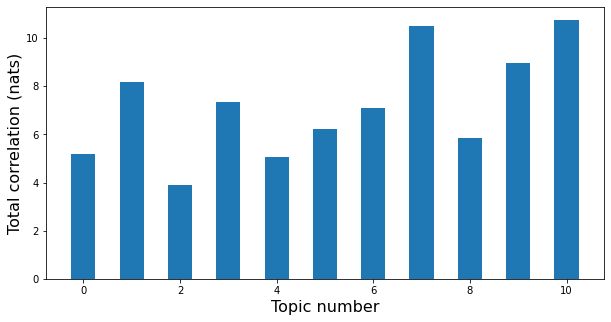

In [14]:
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(range(nlp.anchor_topic_model.tcs.shape[0]),
       nlp.anchor_topic_model.tcs, width=0.5)
plt.xlabel('Topic number', fontsize=16)
plt.ylabel('Total correlation (nats)', fontsize=16)
plt.show()

# Auto-generate MOCs

The `auto_generate_MOCs` function loops over each topic to find the notes that are most relevant to a topic.  In this implementation, I create one MD file per topic (e.g. `topic_0.md`, `topic_1.md`, ...), and write a list of wikilinks to the top 30 notes most relevant to the topic.

In [15]:
out_dir = Path(os.getcwd()) / 'data/out/mphil-mocs'

In [16]:
# remove dir if exists (for ease of iterative changes)
if out_dir.exists():
    try:
        shutil.rmtree(out_dir)
    except OSError:
        os.remove(out_dir)
# make dir:
out_dir.mkdir(parents=True, exist_ok=True)

I sort by `tc`.  The other option with `logp` does not work as well, as dozens of notes are tied for the highest score, which leads to alphabetical sorting on filepaths (not ideal!).

In [17]:
%%time
auto_generate_MOCs(nlp, out_dir=out_dir, top_n_docs=30)

CPU times: user 3.4 ms, sys: 984 µs, total: 4.39 ms
Wall time: 4.15 ms


Let's look at the output for Topic 10's MOC (which was intended to cover the public health module).

In [18]:
with open(out_dir / 'topic_10.md', 'r') as f:
    lines = f.readlines()
    for line in lines[:(2+10)]:  # show only top 10 for this output
        print(line.strip())

# Topic 10
Anchor words: ['public', 'prevention']
- [[Public health policy]]
- [[Ethics]]
- [[Evaluation]]
- [[Risk communication]]
- [[Research ethics]]
- [[Determinants of health]]
- [[Complex system]]
- [[Emergency planning]]
- [[Market]]
- [[Public health]]


The notes that are assigned to the public health module folder are in blue:
![#007bff](https://via.placeholder.com/15/007bff/007bff.png)

In the MOC for this module, most of the notes do in fact relate to that module.  Nonetheless there are a few outside the module that entered the auto-generated MOC.  The earlier image in this notebook shows that there can be some overlap in concepts between modules.  For example, the note I made on 'Public health' was made when studying epidemiology (so I kept _first attribution_ of the note to that module!).

![Topic 10 MOC](../img/MPhil_topic-10-MOC.png)

The notes correspond very well to the main concepts covered in the module.  This makes the MOC very effective for my needs! 👍

In a graph of 800+ notes, it would take me many days to create MOCs from scratch and review the results manually.  I would also be relying on: i) the connections between notes to make MOC generation more efficient; ii) the existing categories that I already use to organise my notes.

In contrast, this approach via topic modelling only took a few hours to implement and tune.  The results it gives are better than what I could have done manually, as it uses all the text in the vault.  The MOC files generated can be 'pruned' by the user as well, if wanting to remove or add specific wikilinks.

# References

- Gallagher, R. J., Reing, K., Kale, D., and Ver Steeg, G. "[Anchored Correlation Explanation: Topic Modeling with Minimal Domain Knowledge](https://www.transacl.org/ojs/index.php/tacl/article/view/1244)." *Transactions of the Association for Computational Linguistics (TACL)*, 2017.